In [4]:
import cv2
import os

In [44]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# try reducing the size of the video

def get_emotion_label(filename):
    parts = filename.split('-')
    emotion_label = int(parts[2])
    emotions = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return emotions.get(emotion_label, "unknown")

def get_frames(video_path, output_dir, frame_rate=1, network_size=(48,48)):
    filename = os.path.basename(video_path)
    emotion_label = get_emotion_label(filename)
    
    #create directory for emotion
    emotion_dir = os.path.join(output_dir, emotion_label)
    os.makedirs(emotion_dir, exist_ok=True)
    
    #read the video
    capture = cv2.VideoCapture(video_path)
    frame_count=0
    success=True
    
    #set frame interval based on the frame rate
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    frame_interval = int(fps / frame_rate)
    
    while success:
        success, frame = capture.read()
        if not success:
            break
        
        compressed_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)  # Scale down by 25%
        gray_frame = cv2.cvtColor(compressed_frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        if len(faces) > 0:
            x, y, w, h = faces[0]  # Use the first detected face
            face = gray_frame[y:y+h, x:x+w]  # Crop the face region
            face_resized = cv2.resize(face, network_size)  # Resize to a standard size for the network
        else:
            print("No face detected in this frame.")
        #save the frame at the specified time interval
        if frame_count % frame_interval == 0:
            frame_filename = f"{filename.split('.')[0]}_frame{frame_count}.jpg"
            frame_path = os.path.join(emotion_dir, frame_filename)
            cv2.imwrite(frame_path, face_resized)
            
        frame_count += 1
        
    capture.release()
    print(f"Extracted frames from {filename} into {emotion_dir}")
    
def process_all_actors(base_dir, output_dir):
    actors = [actor for actor in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, actor))]
    
    for actor in actors:
        actor_path = os.path.join(base_dir, actor)
        videos = [f for f in os.listdir(actor_path) if f.endswith(".mp4")]
        
        for video in videos:
            video_path = os.path.join(actor_path, video)
            get_frames(video_path, output_dir)

In [45]:
video_folder = "C:\\Users\\Lewis\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actor_01"
all_actors_laptop = "C:\\Users\\Lewis\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actors"
all_actors_pc = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\Actors"
output_folder = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\datasetAllActors"

process_all_actors(all_actors_pc, output_folder)

Extracted frames from 01-02-01-01-01-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-01-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-02-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-01-01-02-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\neutral
Extracted frames from 01-02-02-01-01-01-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\calm
Extracted frames from 01-02-02-01-01-02-01.mp4 into C:\Users\paulb\OneDrive - University of Glasgow\Year 4\Facial Emotion Recognition Project\datasetAllActors\calm
Extr

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import re

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        self.actor_ids = [self._extract_actor_id(path) for path, _ in self.samples]

    def _extract_actor_id(self, path):
        filename = os.path.basename(path)
        match = re.search(r'-(\d+)_frame', filename)
        return int(match.group(1)) if match else None

    def get_actor_ids(self):
        return self.actor_ids

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\dataset"
data_dir_all = "C:\\Users\\paulb\\OneDrive - University of Glasgow\\Year 4\\Facial Emotion Recognition Project\\datasetAllActors"

full_dataset = CustomImageFolder(data_dir_all, transform=transform)




In [59]:
from sklearn.model_selection import GroupKFold
import numpy as np

actor_ids = np.array(full_dataset.get_actor_ids())

# Initialize Leave-One-Actor-Out Cross-Validation
group_kfold = GroupKFold(n_splits=len(np.unique(actor_ids)))

# Loop through splits
for train_idx, test_idx in group_kfold.split(np.zeros(len(actor_ids)), groups=actor_ids):
    # Create subsets for training and testing
    train_subset = Subset(full_dataset, train_idx)
    test_subset = Subset(full_dataset, test_idx)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    print(f"Training on actors: {np.unique(actor_ids[train_idx])}")
    print(f"Testing on actor: {np.unique(actor_ids[test_idx])}")
    
    # Train and evaluate your model here

Training on actors: [1 3 4 5 6]
Testing on actor: [2]
Training on actors: [1 2 3 4 6]
Testing on actor: [5]
Training on actors: [1 2 3 4 5]
Testing on actor: [6]
Training on actors: [1 2 4 5 6]
Testing on actor: [3]
Training on actors: [2 3 4 5 6]
Testing on actor: [1]
Training on actors: [1 2 3 5 6]
Testing on actor: [4]


In [ ]:
train_size = int(0.7*len(full_dataset))
test_size = int(0.15*len(full_dataset))
val_size = len(full_dataset) - train_size - test_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleEmotionNN(nn.Module):
    def __init__(self):
        super(SimpleEmotionNN, self).__init__()
        
        #setting up our layers for the NN all the pixels down to the 7 emotion classes
        self.fullyConnected1 = nn.Linear(48*48, 128)
        self.fullyConnected2 = nn.Linear(128, 7)
        
        
    def forward(self, x):
        x = x.view(-1, 48*48)
        x = F.relu(self.fullyConnected1(x))
        x = self.fullyConnected2(x)
        return x

In [75]:
model = SimpleEmotionNN()
print(model)

SimpleEmotionNN(
  (fullyConnected1): Linear(in_features=2304, out_features=128, bias=True)
  (fullyConnected2): Linear(in_features=128, out_features=7, bias=True)
)


In [52]:
# Create a random tensor with shape (batch_size, 1, 48, 48) to simulate a batch of grayscale images
sample_input = torch.randn(32, 1, 48, 48)  # 32 images in the batch

# Pass the sample input through the model
sample_output = model(sample_input)
print("Output shape:", sample_output.shape)

# from my understanding it passes this down through the netwrok to get to a mapping of 7 from the original 2304

Output shape: torch.Size([32, 7])


In [76]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [77]:
model.to(device)

SimpleEmotionNN(
  (fullyConnected1): Linear(in_features=2304, out_features=128, bias=True)
  (fullyConnected2): Linear(in_features=128, out_features=7, bias=True)
)

When the model is reset each time we can see that it doesn't overfit anymore

We can still see there are some actors it learns better than others.

In [106]:
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt


def runModel(model):
    actor_ids = np.array(full_dataset.get_actor_ids())

    # Initialize Leave-One-Actor-Out Cross-Validation
    group_kfold = GroupKFold(n_splits=len(np.unique(actor_ids)))

    # Loop through splits
    for fold, (train_idx, test_idx) in enumerate(group_kfold.split(np.zeros(len(actor_ids)), groups=actor_ids)):
        
        print("Initialising Model...")
        model = SimpleEmotionNN().to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        
        print(f"Training on actors: {np.unique(actor_ids[train_idx])}")
        print(f"Testing on actor: {np.unique(actor_ids[test_idx])}")
        # Create subsets for training and testing
        print(f"\nFold {fold + 1}/{len(np.unique(actor_ids))}")
        
        # Print file paths for training and testing sets
        train_files = [full_dataset.samples[i][0] for i in train_idx]
        test_files = [full_dataset.samples[i][0] for i in test_idx]
        
        
        train_subset = Subset(full_dataset, train_idx)
        test_subset = Subset(full_dataset, test_idx)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
        
        train_losses = []
        test_losses = []
        
        model.train()
        for epoch in range(35):  # Adjust epochs as needed
            total_train_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            # Evaluate on test set
            model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    total_test_loss += loss.item()
            
            avg_test_loss = total_test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")
            

            # Plot loss and accuracy curves for this fold
        plt.figure(figsize=(12, 5))
        
        # Loss plot
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title(f'Fold {fold + 1} Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()  

In [108]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 64*12*12)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return F.log_softmax(x, dim=1)

Initialising Model...
Training on actors: [1 3 4 5 6]
Testing on actor: [2]

Fold 1/6
Epoch 1: Train Loss = 1.8872, Test Loss = 1.8557
Epoch 2: Train Loss = 1.8142, Test Loss = 1.8216
Epoch 3: Train Loss = 1.7643, Test Loss = 1.7987
Epoch 4: Train Loss = 1.7240, Test Loss = 1.7829
Epoch 5: Train Loss = 1.6874, Test Loss = 1.7731
Epoch 6: Train Loss = 1.6515, Test Loss = 1.7637
Epoch 7: Train Loss = 1.6215, Test Loss = 1.7564
Epoch 8: Train Loss = 1.5875, Test Loss = 1.7494
Epoch 9: Train Loss = 1.5550, Test Loss = 1.7469
Epoch 10: Train Loss = 1.5236, Test Loss = 1.7461
Epoch 11: Train Loss = 1.4919, Test Loss = 1.7412
Epoch 12: Train Loss = 1.4690, Test Loss = 1.7535
Epoch 13: Train Loss = 1.4370, Test Loss = 1.7477
Epoch 14: Train Loss = 1.4203, Test Loss = 1.7589
Epoch 15: Train Loss = 1.3860, Test Loss = 1.7704
Epoch 16: Train Loss = 1.3542, Test Loss = 1.7731
Epoch 17: Train Loss = 1.3313, Test Loss = 1.7843
Epoch 18: Train Loss = 1.3077, Test Loss = 1.8032
Epoch 19: Train Loss = 

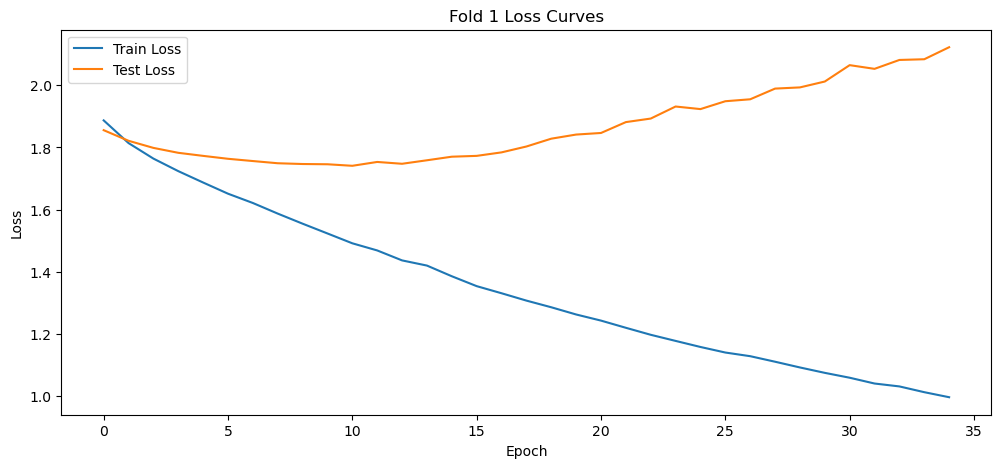

Initialising Model...
Training on actors: [1 2 3 4 6]
Testing on actor: [5]

Fold 2/6
Epoch 1: Train Loss = 1.9189, Test Loss = 1.9426
Epoch 2: Train Loss = 1.8517, Test Loss = 1.8938
Epoch 3: Train Loss = 1.8051, Test Loss = 1.8578
Epoch 4: Train Loss = 1.7665, Test Loss = 1.8337
Epoch 5: Train Loss = 1.7332, Test Loss = 1.8156
Epoch 6: Train Loss = 1.7035, Test Loss = 1.7985
Epoch 7: Train Loss = 1.6749, Test Loss = 1.7880
Epoch 8: Train Loss = 1.6463, Test Loss = 1.7769
Epoch 9: Train Loss = 1.6196, Test Loss = 1.7772
Epoch 10: Train Loss = 1.5927, Test Loss = 1.7730
Epoch 11: Train Loss = 1.5657, Test Loss = 1.7725
Epoch 12: Train Loss = 1.5403, Test Loss = 1.7725
Epoch 13: Train Loss = 1.5158, Test Loss = 1.7744
Epoch 14: Train Loss = 1.4900, Test Loss = 1.7829
Epoch 15: Train Loss = 1.4664, Test Loss = 1.7825
Epoch 16: Train Loss = 1.4427, Test Loss = 1.7974
Epoch 17: Train Loss = 1.4199, Test Loss = 1.8169
Epoch 18: Train Loss = 1.3999, Test Loss = 1.8131
Epoch 19: Train Loss = 

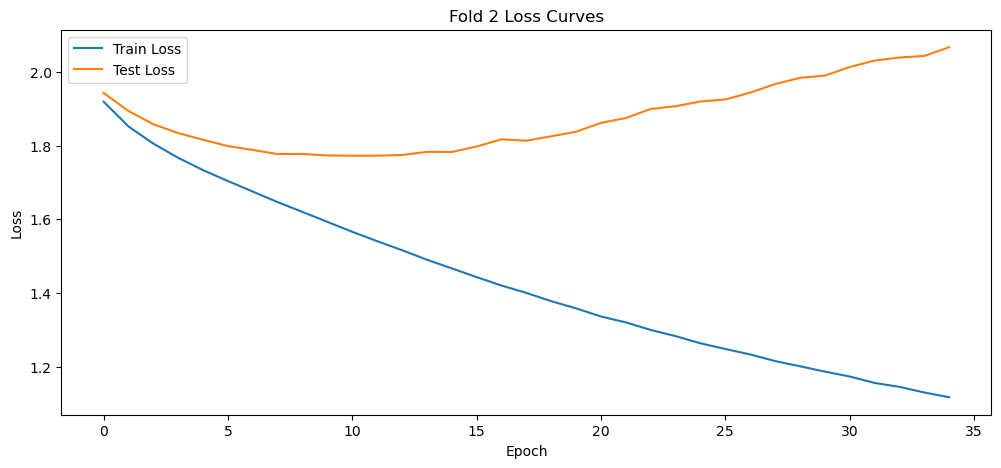

Initialising Model...
Training on actors: [1 2 3 4 5]
Testing on actor: [6]

Fold 3/6
Epoch 1: Train Loss = 1.9048, Test Loss = 1.8814
Epoch 2: Train Loss = 1.8404, Test Loss = 1.8436
Epoch 3: Train Loss = 1.7904, Test Loss = 1.8120
Epoch 4: Train Loss = 1.7483, Test Loss = 1.7838
Epoch 5: Train Loss = 1.7118, Test Loss = 1.7599
Epoch 6: Train Loss = 1.6791, Test Loss = 1.7406
Epoch 7: Train Loss = 1.6483, Test Loss = 1.7221
Epoch 8: Train Loss = 1.6186, Test Loss = 1.7059
Epoch 9: Train Loss = 1.5908, Test Loss = 1.6884
Epoch 10: Train Loss = 1.5637, Test Loss = 1.6718
Epoch 11: Train Loss = 1.5378, Test Loss = 1.6578
Epoch 12: Train Loss = 1.5114, Test Loss = 1.6447
Epoch 13: Train Loss = 1.4870, Test Loss = 1.6328
Epoch 14: Train Loss = 1.4630, Test Loss = 1.6196
Epoch 15: Train Loss = 1.4396, Test Loss = 1.6107
Epoch 16: Train Loss = 1.4165, Test Loss = 1.6009
Epoch 17: Train Loss = 1.3942, Test Loss = 1.5911
Epoch 18: Train Loss = 1.3726, Test Loss = 1.5866
Epoch 19: Train Loss = 

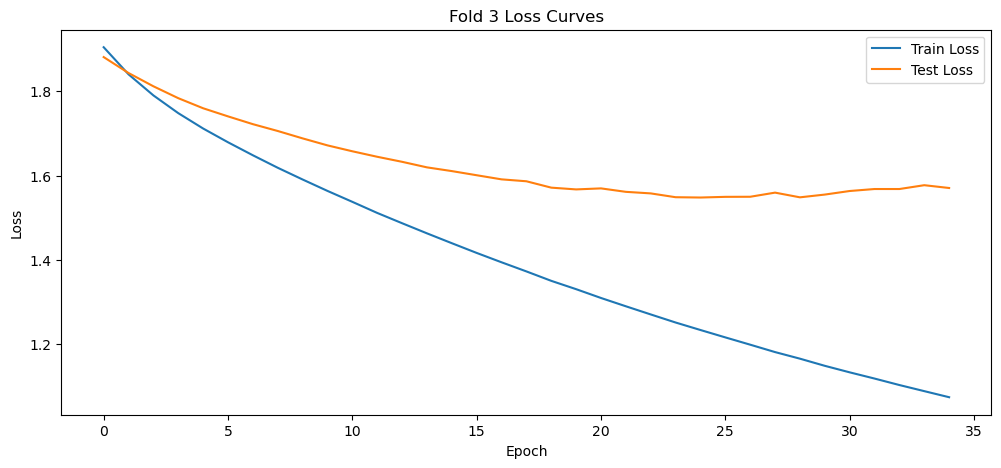

Initialising Model...
Training on actors: [1 2 4 5 6]
Testing on actor: [3]

Fold 4/6
Epoch 1: Train Loss = 1.8950, Test Loss = 1.8860
Epoch 2: Train Loss = 1.8362, Test Loss = 1.8409
Epoch 3: Train Loss = 1.7927, Test Loss = 1.8050
Epoch 4: Train Loss = 1.7566, Test Loss = 1.7755
Epoch 5: Train Loss = 1.7268, Test Loss = 1.7516
Epoch 6: Train Loss = 1.7003, Test Loss = 1.7275
Epoch 7: Train Loss = 1.6793, Test Loss = 1.7054
Epoch 8: Train Loss = 1.6539, Test Loss = 1.6807
Epoch 9: Train Loss = 1.6366, Test Loss = 1.6622
Epoch 10: Train Loss = 1.6141, Test Loss = 1.6418
Epoch 11: Train Loss = 1.5917, Test Loss = 1.6268
Epoch 12: Train Loss = 1.5841, Test Loss = 1.6056
Epoch 13: Train Loss = 1.5507, Test Loss = 1.5831
Epoch 14: Train Loss = 1.5326, Test Loss = 1.5685
Epoch 15: Train Loss = 1.5096, Test Loss = 1.5440
Epoch 16: Train Loss = 1.4937, Test Loss = 1.5315
Epoch 17: Train Loss = 1.4735, Test Loss = 1.5188
Epoch 18: Train Loss = 1.4555, Test Loss = 1.4987
Epoch 19: Train Loss = 

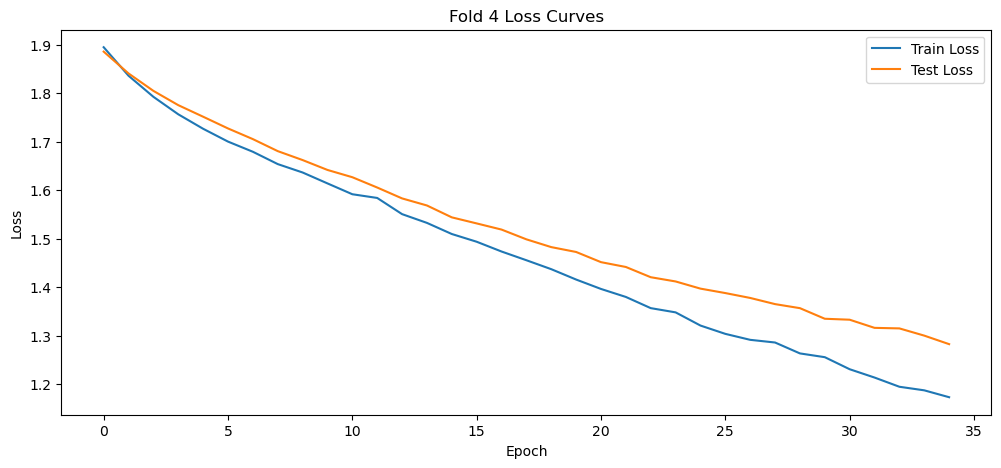

Initialising Model...
Training on actors: [2 3 4 5 6]
Testing on actor: [1]

Fold 5/6
Epoch 1: Train Loss = 1.9057, Test Loss = 1.8810
Epoch 2: Train Loss = 1.8428, Test Loss = 1.8418
Epoch 3: Train Loss = 1.7946, Test Loss = 1.8135
Epoch 4: Train Loss = 1.7562, Test Loss = 1.7904
Epoch 5: Train Loss = 1.7215, Test Loss = 1.7706
Epoch 6: Train Loss = 1.6922, Test Loss = 1.7503
Epoch 7: Train Loss = 1.6596, Test Loss = 1.7329
Epoch 8: Train Loss = 1.6299, Test Loss = 1.7160
Epoch 9: Train Loss = 1.6044, Test Loss = 1.7015
Epoch 10: Train Loss = 1.5784, Test Loss = 1.6851
Epoch 11: Train Loss = 1.5503, Test Loss = 1.6712
Epoch 12: Train Loss = 1.5235, Test Loss = 1.6541
Epoch 13: Train Loss = 1.5023, Test Loss = 1.6435
Epoch 14: Train Loss = 1.4711, Test Loss = 1.6271
Epoch 15: Train Loss = 1.4514, Test Loss = 1.6130
Epoch 16: Train Loss = 1.4236, Test Loss = 1.6059
Epoch 17: Train Loss = 1.4012, Test Loss = 1.5906
Epoch 18: Train Loss = 1.3779, Test Loss = 1.5816
Epoch 19: Train Loss = 

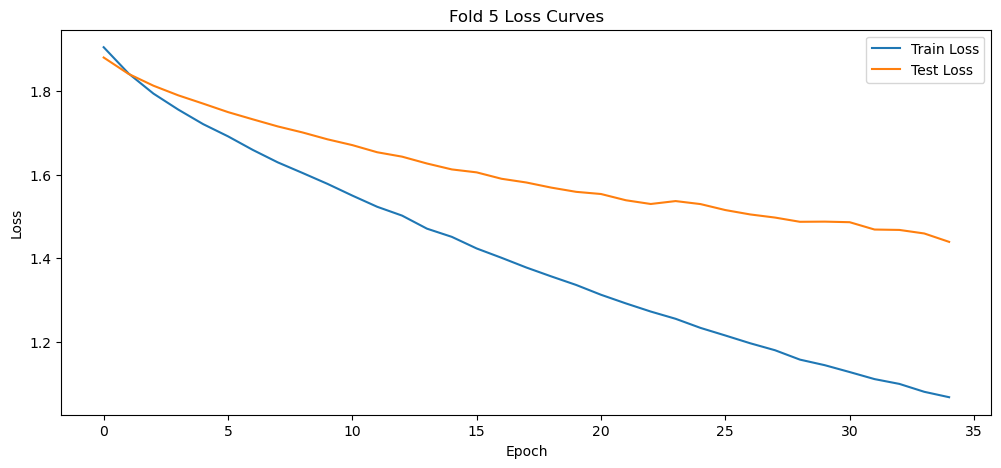

Initialising Model...
Training on actors: [1 2 3 5 6]
Testing on actor: [4]

Fold 6/6
Epoch 1: Train Loss = 1.9206, Test Loss = 1.8660
Epoch 2: Train Loss = 1.8381, Test Loss = 1.8230
Epoch 3: Train Loss = 1.7843, Test Loss = 1.7959
Epoch 4: Train Loss = 1.7411, Test Loss = 1.7776
Epoch 5: Train Loss = 1.7050, Test Loss = 1.7638
Epoch 6: Train Loss = 1.6707, Test Loss = 1.7508
Epoch 7: Train Loss = 1.6389, Test Loss = 1.7433
Epoch 8: Train Loss = 1.6100, Test Loss = 1.7331
Epoch 9: Train Loss = 1.5791, Test Loss = 1.7271
Epoch 10: Train Loss = 1.5521, Test Loss = 1.7272
Epoch 11: Train Loss = 1.5235, Test Loss = 1.7208
Epoch 12: Train Loss = 1.4967, Test Loss = 1.7173
Epoch 13: Train Loss = 1.4713, Test Loss = 1.7241
Epoch 14: Train Loss = 1.4474, Test Loss = 1.7298
Epoch 15: Train Loss = 1.4225, Test Loss = 1.7144
Epoch 16: Train Loss = 1.3990, Test Loss = 1.7215
Epoch 17: Train Loss = 1.3751, Test Loss = 1.7255
Epoch 18: Train Loss = 1.3532, Test Loss = 1.7263
Epoch 19: Train Loss = 

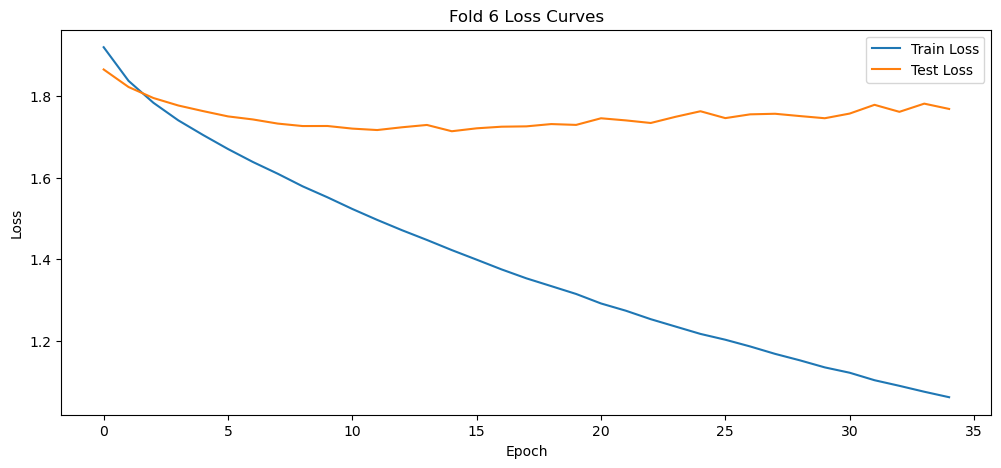

In [110]:
runModel(SimpleEmotionNN)

Initialising Model...
Training on actors: [1 3 4 5 6]
Testing on actor: [2]

Fold 1/6
Epoch 1: Train Loss = 1.8955, Test Loss = 1.8871
Epoch 2: Train Loss = 1.8243, Test Loss = 1.8499
Epoch 3: Train Loss = 1.7711, Test Loss = 1.8249
Epoch 4: Train Loss = 1.7272, Test Loss = 1.8042
Epoch 5: Train Loss = 1.6885, Test Loss = 1.7881
Epoch 6: Train Loss = 1.6509, Test Loss = 1.7727
Epoch 7: Train Loss = 1.6207, Test Loss = 1.7611
Epoch 8: Train Loss = 1.5861, Test Loss = 1.7503
Epoch 9: Train Loss = 1.5596, Test Loss = 1.7526
Epoch 10: Train Loss = 1.5271, Test Loss = 1.7524
Epoch 11: Train Loss = 1.4929, Test Loss = 1.7481
Epoch 12: Train Loss = 1.4631, Test Loss = 1.7593
Epoch 13: Train Loss = 1.4380, Test Loss = 1.7534
Epoch 14: Train Loss = 1.4112, Test Loss = 1.7658
Epoch 15: Train Loss = 1.3847, Test Loss = 1.7715
Epoch 16: Train Loss = 1.3567, Test Loss = 1.7754
Epoch 17: Train Loss = 1.3308, Test Loss = 1.7788
Epoch 18: Train Loss = 1.3085, Test Loss = 1.8226
Epoch 19: Train Loss = 

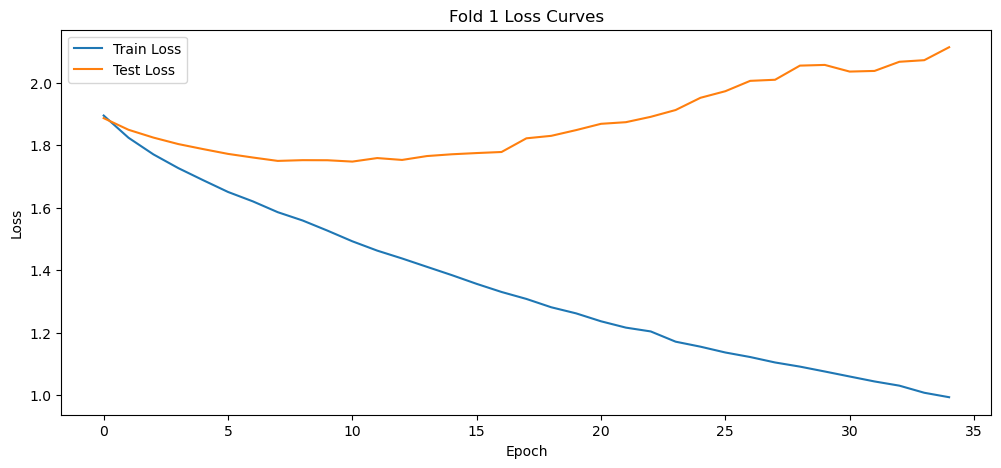

Initialising Model...
Training on actors: [1 2 3 4 6]
Testing on actor: [5]

Fold 2/6
Epoch 1: Train Loss = 1.9079, Test Loss = 1.8760
Epoch 2: Train Loss = 1.8335, Test Loss = 1.8314
Epoch 3: Train Loss = 1.7796, Test Loss = 1.7996
Epoch 4: Train Loss = 1.7377, Test Loss = 1.7789
Epoch 5: Train Loss = 1.7027, Test Loss = 1.7585
Epoch 6: Train Loss = 1.6713, Test Loss = 1.7462
Epoch 7: Train Loss = 1.6395, Test Loss = 1.7368
Epoch 8: Train Loss = 1.6127, Test Loss = 1.7282
Epoch 9: Train Loss = 1.5848, Test Loss = 1.7208
Epoch 10: Train Loss = 1.5591, Test Loss = 1.7223
Epoch 11: Train Loss = 1.5336, Test Loss = 1.7134
Epoch 12: Train Loss = 1.5096, Test Loss = 1.7138
Epoch 13: Train Loss = 1.4856, Test Loss = 1.7173
Epoch 14: Train Loss = 1.4630, Test Loss = 1.7251
Epoch 15: Train Loss = 1.4402, Test Loss = 1.7309
Epoch 16: Train Loss = 1.4216, Test Loss = 1.7407
Epoch 17: Train Loss = 1.3993, Test Loss = 1.7423
Epoch 18: Train Loss = 1.3773, Test Loss = 1.7557
Epoch 19: Train Loss = 

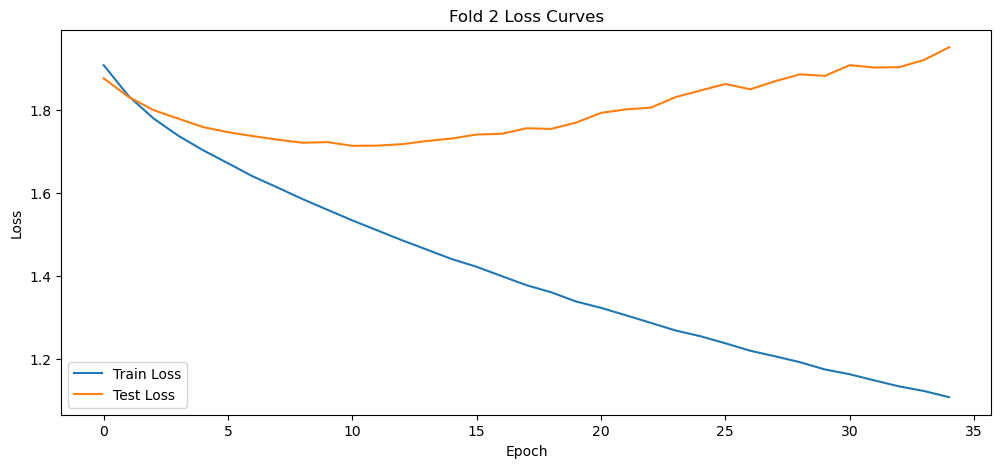

Initialising Model...
Training on actors: [1 2 3 4 5]
Testing on actor: [6]

Fold 3/6
Epoch 1: Train Loss = 1.9073, Test Loss = 1.8824
Epoch 2: Train Loss = 1.8255, Test Loss = 1.8279
Epoch 3: Train Loss = 1.7706, Test Loss = 1.7891
Epoch 4: Train Loss = 1.7276, Test Loss = 1.7600
Epoch 5: Train Loss = 1.6913, Test Loss = 1.7366
Epoch 6: Train Loss = 1.6580, Test Loss = 1.7156
Epoch 7: Train Loss = 1.6270, Test Loss = 1.6983
Epoch 8: Train Loss = 1.5977, Test Loss = 1.6812
Epoch 9: Train Loss = 1.5695, Test Loss = 1.6675
Epoch 10: Train Loss = 1.5425, Test Loss = 1.6537
Epoch 11: Train Loss = 1.5163, Test Loss = 1.6441
Epoch 12: Train Loss = 1.4915, Test Loss = 1.6319
Epoch 13: Train Loss = 1.4667, Test Loss = 1.6197
Epoch 14: Train Loss = 1.4435, Test Loss = 1.6148
Epoch 15: Train Loss = 1.4207, Test Loss = 1.6072
Epoch 16: Train Loss = 1.3993, Test Loss = 1.5979
Epoch 17: Train Loss = 1.3769, Test Loss = 1.5963
Epoch 18: Train Loss = 1.3564, Test Loss = 1.5899
Epoch 19: Train Loss = 

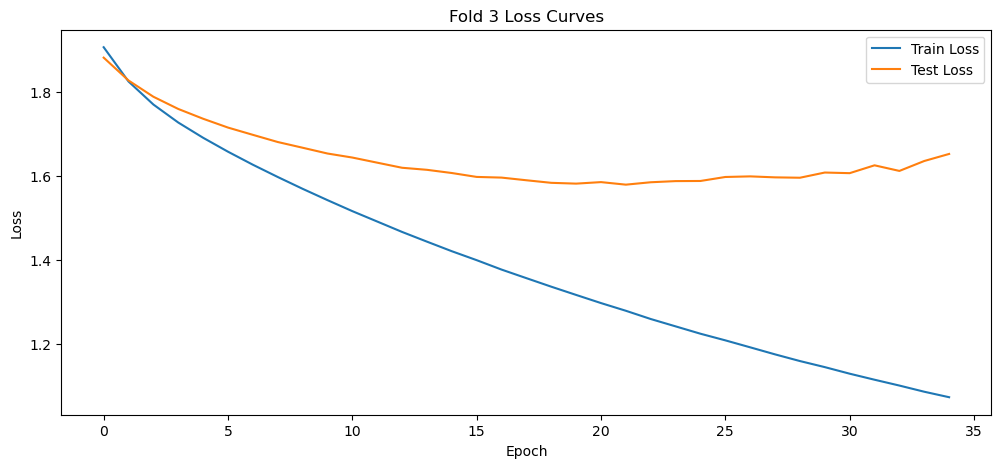

Initialising Model...
Training on actors: [1 2 4 5 6]
Testing on actor: [3]

Fold 4/6
Epoch 1: Train Loss = 1.9052, Test Loss = 1.8717
Epoch 2: Train Loss = 1.8307, Test Loss = 1.8252
Epoch 3: Train Loss = 1.7828, Test Loss = 1.7898
Epoch 4: Train Loss = 1.7453, Test Loss = 1.7629
Epoch 5: Train Loss = 1.7164, Test Loss = 1.7335
Epoch 6: Train Loss = 1.6860, Test Loss = 1.7090
Epoch 7: Train Loss = 1.6594, Test Loss = 1.6823
Epoch 8: Train Loss = 1.6314, Test Loss = 1.6587
Epoch 9: Train Loss = 1.6065, Test Loss = 1.6360
Epoch 10: Train Loss = 1.5864, Test Loss = 1.6136
Epoch 11: Train Loss = 1.5530, Test Loss = 1.5866
Epoch 12: Train Loss = 1.5403, Test Loss = 1.5650
Epoch 13: Train Loss = 1.5133, Test Loss = 1.5430
Epoch 14: Train Loss = 1.4900, Test Loss = 1.5306
Epoch 15: Train Loss = 1.4651, Test Loss = 1.5138
Epoch 16: Train Loss = 1.4479, Test Loss = 1.4999
Epoch 17: Train Loss = 1.4378, Test Loss = 1.4771
Epoch 18: Train Loss = 1.4085, Test Loss = 1.4655
Epoch 19: Train Loss = 

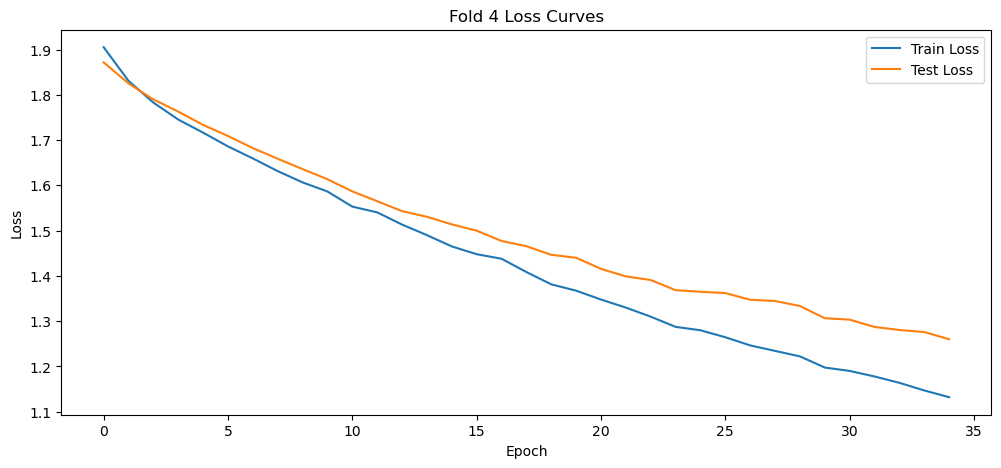

Initialising Model...
Training on actors: [2 3 4 5 6]
Testing on actor: [1]

Fold 5/6
Epoch 1: Train Loss = 1.8911, Test Loss = 1.8720
Epoch 2: Train Loss = 1.8218, Test Loss = 1.8253
Epoch 3: Train Loss = 1.7708, Test Loss = 1.7913
Epoch 4: Train Loss = 1.7286, Test Loss = 1.7648
Epoch 5: Train Loss = 1.6911, Test Loss = 1.7451
Epoch 6: Train Loss = 1.6598, Test Loss = 1.7261
Epoch 7: Train Loss = 1.6293, Test Loss = 1.7093
Epoch 8: Train Loss = 1.6002, Test Loss = 1.6930
Epoch 9: Train Loss = 1.5769, Test Loss = 1.6771
Epoch 10: Train Loss = 1.5448, Test Loss = 1.6632
Epoch 11: Train Loss = 1.5217, Test Loss = 1.6503
Epoch 12: Train Loss = 1.4958, Test Loss = 1.6407
Epoch 13: Train Loss = 1.4719, Test Loss = 1.6241
Epoch 14: Train Loss = 1.4456, Test Loss = 1.6090
Epoch 15: Train Loss = 1.4217, Test Loss = 1.6033
Epoch 16: Train Loss = 1.3943, Test Loss = 1.5894
Epoch 17: Train Loss = 1.3772, Test Loss = 1.5835
Epoch 18: Train Loss = 1.3529, Test Loss = 1.5691
Epoch 19: Train Loss = 

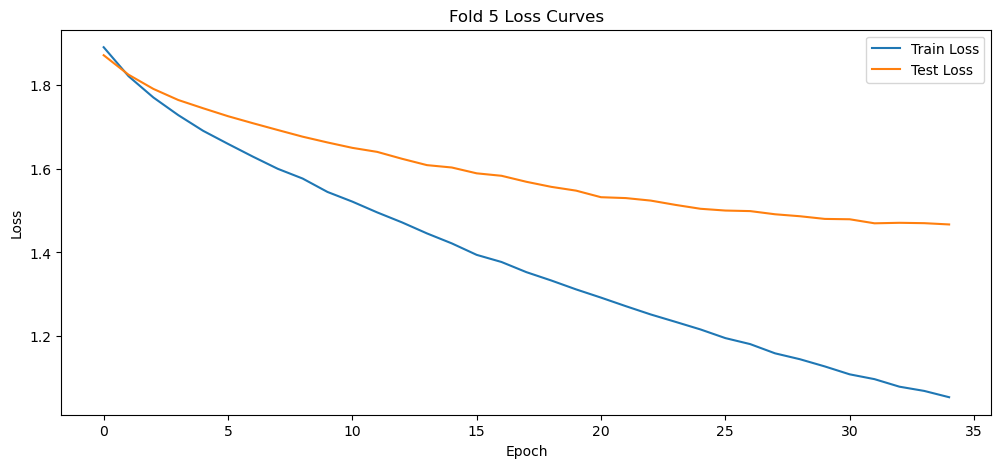

Initialising Model...
Training on actors: [1 2 3 5 6]
Testing on actor: [4]

Fold 6/6
Epoch 1: Train Loss = 1.9134, Test Loss = 1.8862
Epoch 2: Train Loss = 1.8359, Test Loss = 1.8414
Epoch 3: Train Loss = 1.7831, Test Loss = 1.8142
Epoch 4: Train Loss = 1.7431, Test Loss = 1.7952
Epoch 5: Train Loss = 1.7072, Test Loss = 1.7799
Epoch 6: Train Loss = 1.6742, Test Loss = 1.7683
Epoch 7: Train Loss = 1.6439, Test Loss = 1.7556
Epoch 8: Train Loss = 1.6138, Test Loss = 1.7481
Epoch 9: Train Loss = 1.5840, Test Loss = 1.7467
Epoch 10: Train Loss = 1.5557, Test Loss = 1.7390
Epoch 11: Train Loss = 1.5283, Test Loss = 1.7329
Epoch 12: Train Loss = 1.5008, Test Loss = 1.7359
Epoch 13: Train Loss = 1.4768, Test Loss = 1.7360
Epoch 14: Train Loss = 1.4532, Test Loss = 1.7325
Epoch 15: Train Loss = 1.4285, Test Loss = 1.7329
Epoch 16: Train Loss = 1.4065, Test Loss = 1.7401
Epoch 17: Train Loss = 1.3832, Test Loss = 1.7349
Epoch 18: Train Loss = 1.3597, Test Loss = 1.7333
Epoch 19: Train Loss = 

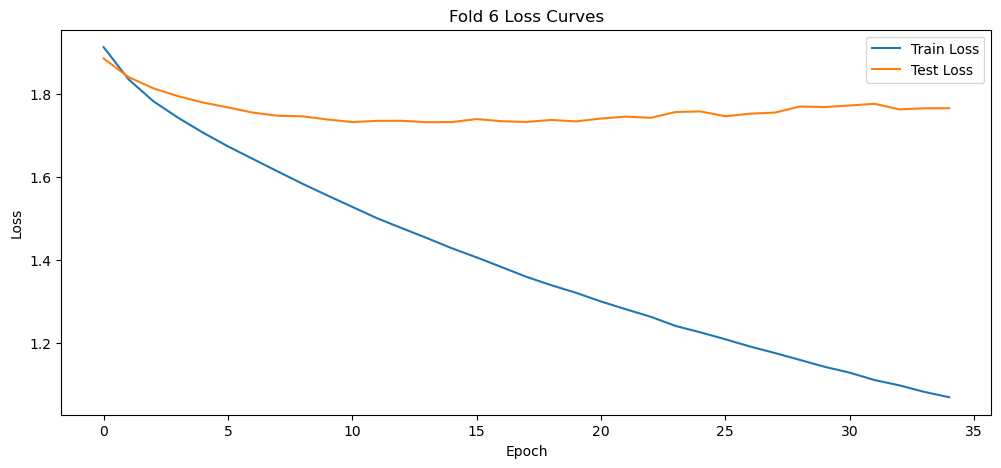

In [109]:
runModel(EmotionCNN)

In [87]:
import torch

dummy = torch.rand(1,1,48,48)
print(dummy.shape)

torch.Size([1, 1, 48, 48])


In [ ]:
import torch.nn as nn

conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1,padding=1)

conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

feature_maps1 = conv1(dummy)
print(feature_maps1.shape)
feature_maps2 = conv2(feature_maps1)
print(feature_maps2.shape)


torch.Size([1, 32, 48, 48])
torch.Size([1, 64, 48, 48])


In [95]:
import torch.nn.functional as F

activated_maps1 = F.relu(feature_maps1)
activated_maps2 = F.relu(feature_maps2)

print(activated_maps1.shape)
print(activated_maps2.shape)

torch.Size([1, 32, 48, 48])
torch.Size([1, 64, 48, 48])


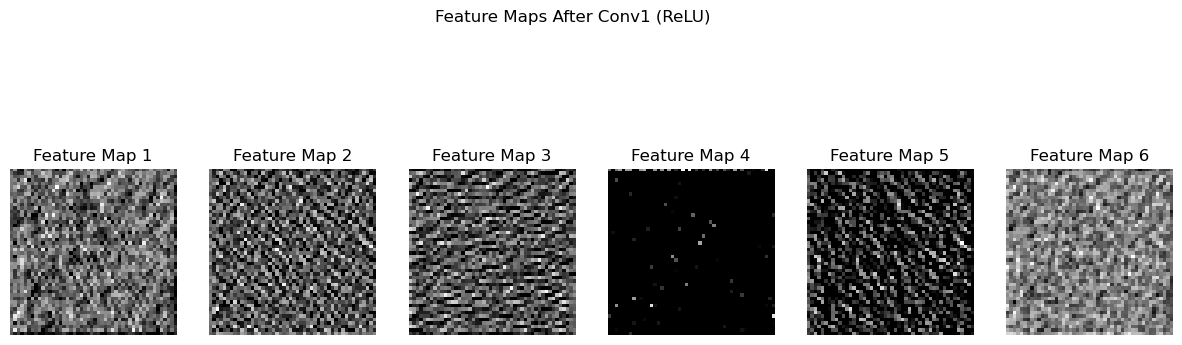

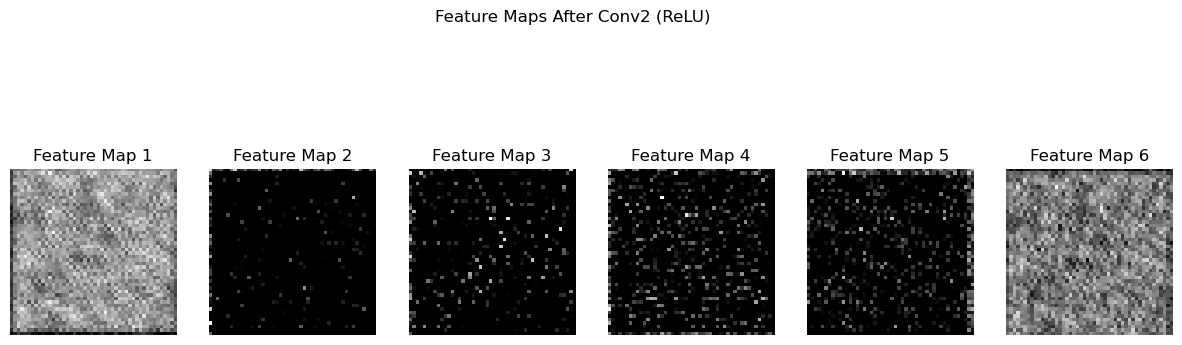

In [99]:
import matplotlib.pyplot as plt

def plot_feature_maps(feature_maps, title):
    num_maps = feature_maps.shape[1]  # Number of feature maps
    fig, axes = plt.subplots(1, min(6, num_maps), figsize=(15, 5))  # Plot up to 6 feature maps
    
    for i in range(min(6, num_maps)):  # Limit to first 6 feature maps
        axes[i].imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='gray')  # Convert to numpy for plotting
        axes[i].axis('off')
        axes[i].set_title(f"Feature Map {i+1}")
    
    plt.suptitle(title)
    plt.show()

# Plot feature maps after the first convolution
plot_feature_maps(activated_maps1, title="Feature Maps After Conv1 (ReLU)")

# Plot feature maps after the second convolution
plot_feature_maps(activated_maps2, title="Feature Maps After Conv2 (ReLU)")


In [102]:
pool = nn.MaxPool2d(kernel_size=2, stride=2) #reduces by half

pooled_maps1 = pool(activated_maps1)
print(pooled_maps1.shape)
pooled_maps2 = pool(activated_maps2)
print(pooled_maps2.shape)

torch.Size([1, 32, 24, 24])
torch.Size([1, 64, 24, 24])


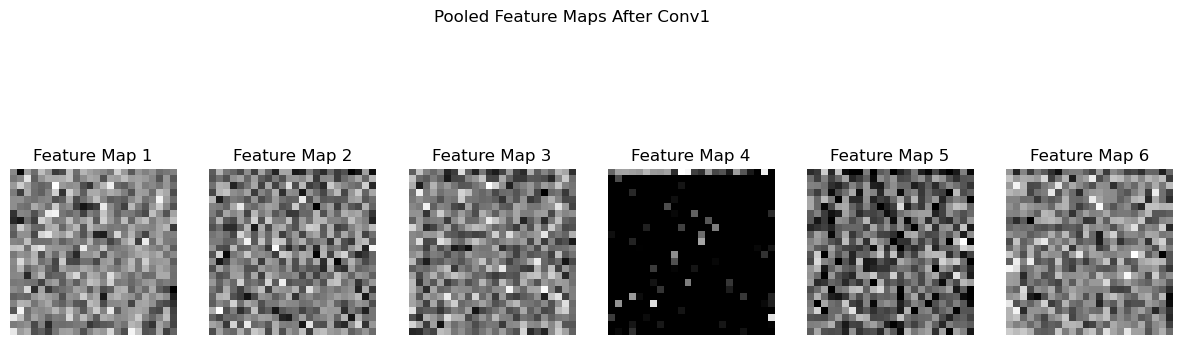

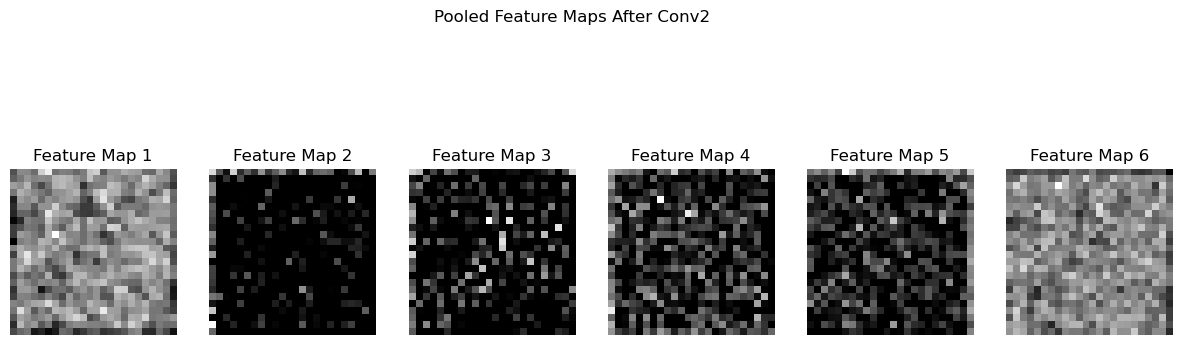

In [104]:
# Plot pooled feature maps after the first convolution
plot_feature_maps(pooled_maps1, title="Pooled Feature Maps After Conv1")

# Plot pooled feature maps after the second convolution
plot_feature_maps(pooled_maps2, title="Pooled Feature Maps After Conv2")


In [105]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 64*12*12)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return F.log_softmax(x, dim=1)